# Weekly CO₂ at Mauna Loa – Keeling Curve (Time Series Analysis)

**Author:** Hanae Tafza  
**Dataset:** Weekly in situ CO₂ at Mauna Loa Observatory (Scripps CO₂ Program)  
**Download date:** 3 December 2025  

In this notebook, I analyze the weekly atmospheric CO₂ concentration at Mauna Loa Observatory
(started by Charles David Keeling in 1958, known as the *Keeling Curve*).

**Goals:**

1. Plot the raw weekly series to show the **superposition** of:
   - a **periodic oscillation** (seasonal cycle),
   - and a **slow long-term trend** (systematic increase).

2. **Separate** these two phenomena:
   - extract the seasonal component,
   - extract the long-term trend,
   - characterize the periodic oscillation (amplitude, timing).

3. Fit a **simple model** for the slow contribution (trend), estimate its parameters,
   and **extrapolate** it to 2025 (for model validation using recent observations).


## 1. Imports and Setup

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from io import StringIO

sns.set(style="whitegrid", font_scale=1.2)
plt.rcParams["figure.figsize"] = (14, 6)


## 2. Loading the Weekly Scripps CO₂ Data

We use the **weekly in situ CO₂ data** from the Scripps CO₂ Program at Mauna Loa.  
Official page: <https://scrippsco2.ucsd.edu/data/atmospheric_co2/weekly_in_situ_co2/>

For this document, we download the CSV directly from the Scripps website.  
In a real reproducible workflow, we would store a **local copy** in the Git repository with the download date (here: 3 December 2025).

In [18]:

csv_path = "/content/weekly_in_situ_co2_mlo.csv"  # adapt later for your repo

# Read as text and keep only data lines that start with a digit (YYYY-..)
with open(csv_path, "r") as f:
    lines = f.readlines()

data_lines = [line for line in lines if line.strip() and line.strip()[0].isdigit()]

print("Number of data lines:", len(data_lines))
print("First 5 data lines:\n", "".join(data_lines[:5]))

# Build a clean CSV in memory
data_str = "".join(data_lines)
df_raw = pd.read_csv(StringIO(data_str), header=None, names=["date", "co2"])

df_raw.head()





Number of data lines: 3457
First 5 data lines:
 1958-03-29, 316.19
1958-04-05, 317.31
1958-04-12, 317.69
1958-04-19, 317.58
1958-04-26, 316.48



,date,co2
0,1958-03-29,316.19
1,1958-04-05,317.31
2,1958-04-12,317.69
3,1958-04-19,317.58
4,1958-04-26,316.48


In [19]:
# Convert date to datetime and CO2 to float
df_raw["date"] = pd.to_datetime(df_raw["date"], format="%Y-%m-%d")
df_raw["co2"] = pd.to_numeric(df_raw["co2"], errors="coerce")

# Check basic info
print(df_raw.info())
df_raw.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3457 entries, 0 to 3456
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3457 non-null   datetime64[ns]
 1   co2     3457 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 54.1 KB
None


,date,co2
count,3457,3457.000000
mean,1992-06-17 01:52:28.047440,360.980304
min,1958-03-29 00:00:00,313.040000
25%,1975-10-25 00:00:00,331.940000
50%,1992-06-27 00:00:00,356.210000
75%,2009-03-28 00:00:00,386.910000
max,2025-11-29 00:00:00,430.500000
std,NaN,32.585174


In [20]:
# Sort by date, drop NaNs at extremes, interpolate inside
df = df_raw.sort_values("date").set_index("date")
df = df.asfreq("W-SAT")  # one value per Saturday (weekly approx)
df["co2"] = df["co2"].interpolate()

df.head(), df.tail()

(               co2
 date              
 1958-03-29  316.19
 1958-04-05  317.31
 1958-04-12  317.69
 1958-04-19  317.58
 1958-04-26  316.48,
                co2
 date              
 2025-11-01  424.90
 2025-11-08  425.06
 2025-11-15  426.55
 2025-11-22  426.08
 2025-11-29  426.64)

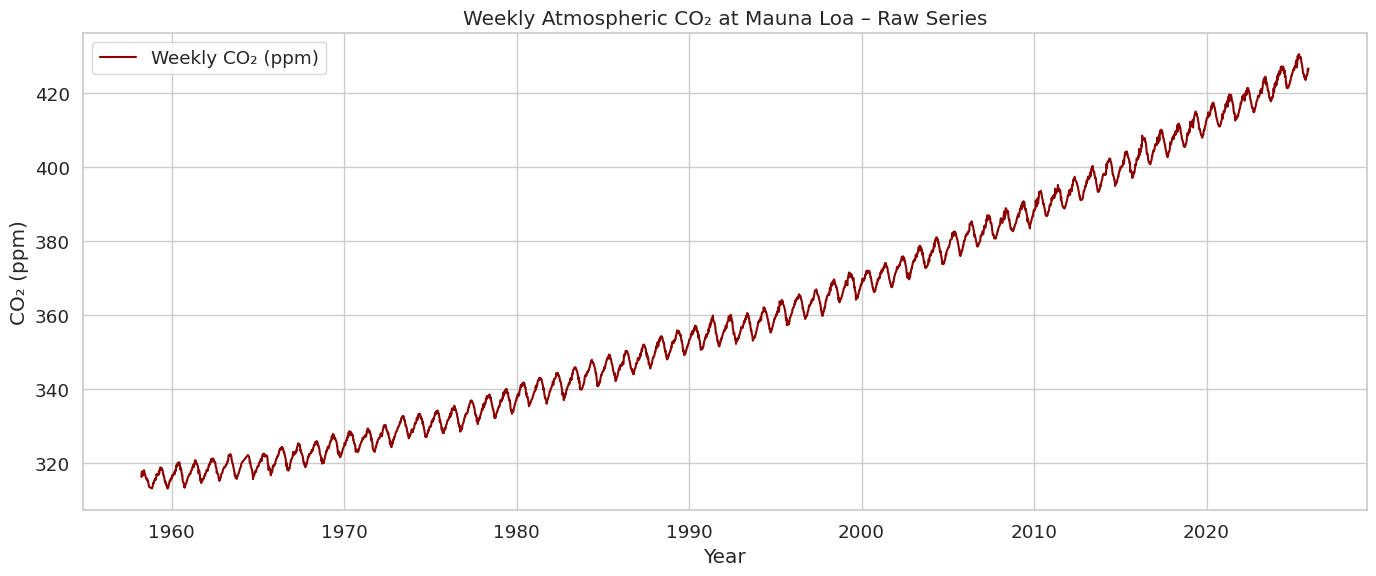

In [21]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df["co2"], label="Weekly CO₂ (ppm)", color="darkred")
plt.title("Weekly Atmospheric CO₂ at Mauna Loa – Raw Series")
plt.xlabel("Year")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.tight_layout()
plt.show()


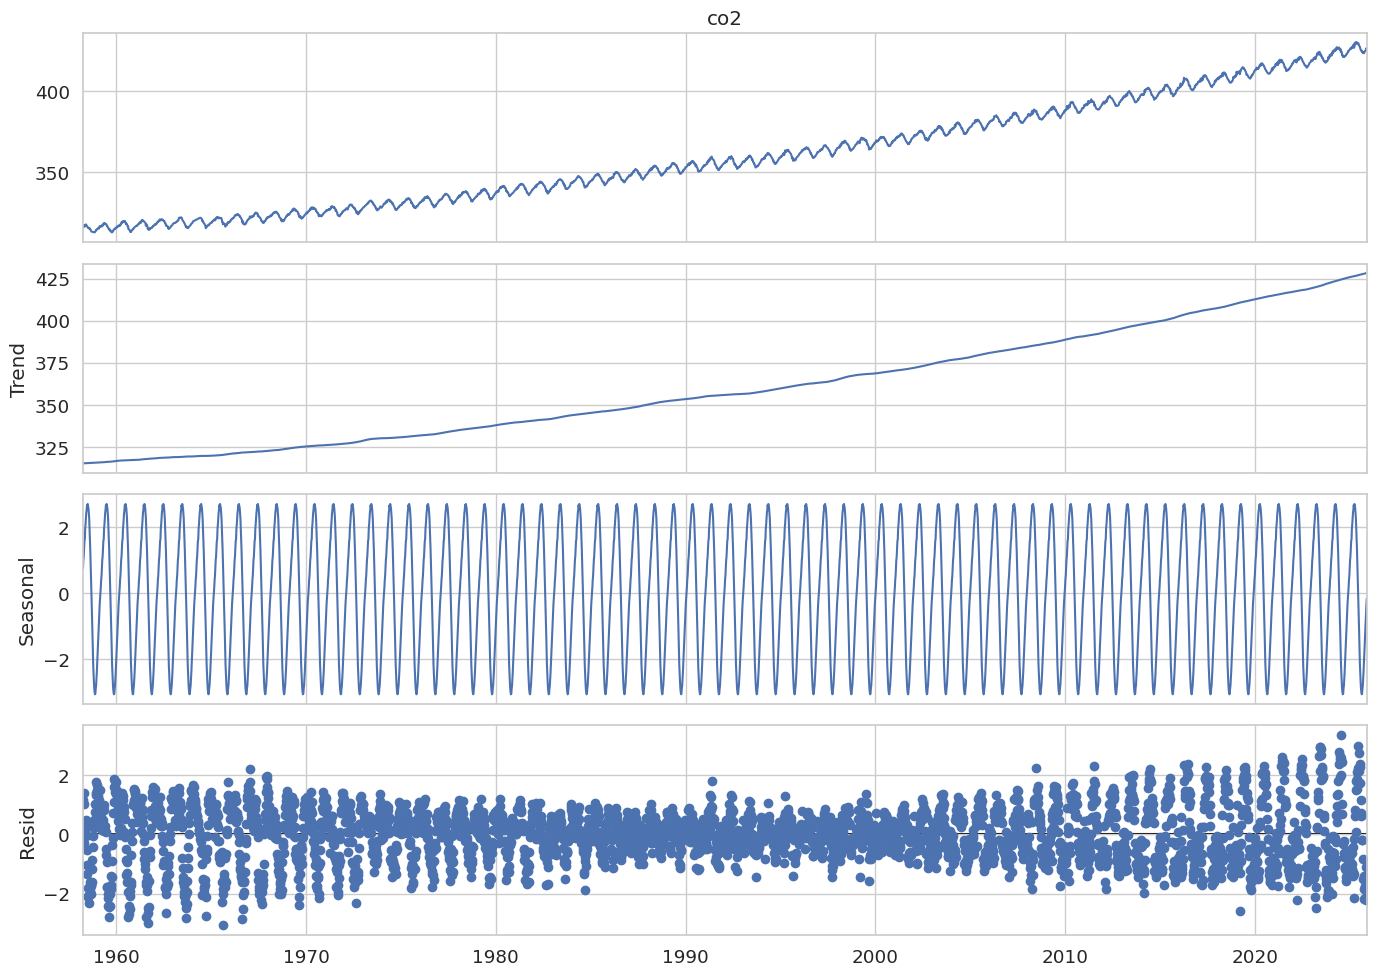

In [22]:
result = seasonal_decompose(df["co2"], model="additive", period=52, extrapolate_trend="freq")

trend = result.trend
seasonal = result.seasonal
resid = result.resid

fig = result.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()


Seasonal amplitude (max - min): 5.08 ppm
Peak CO₂ seasonal effect around week: 19
Minimum CO₂ seasonal effect around week: 40


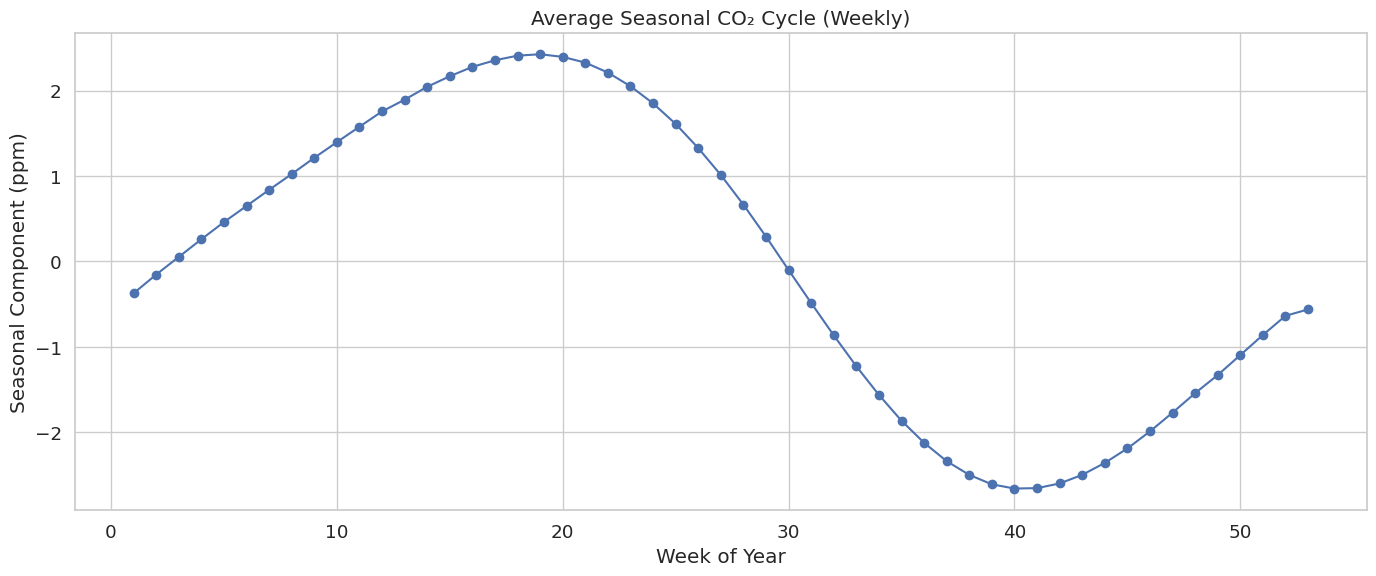

In [23]:
seasonal_df = seasonal.dropna().to_frame(name="seasonal").copy()
seasonal_df["week_of_year"] = seasonal_df.index.isocalendar().week

weekly_seasonal = seasonal_df.groupby("week_of_year")["seasonal"].mean()

amp = weekly_seasonal.max() - weekly_seasonal.min()
peak_week = int(weekly_seasonal.idxmax())
trough_week = int(weekly_seasonal.idxmin())

print(f"Seasonal amplitude (max - min): {amp:.2f} ppm")
print(f"Peak CO₂ seasonal effect around week: {peak_week}")
print(f"Minimum CO₂ seasonal effect around week: {trough_week}")

plt.figure(figsize=(14, 6))
plt.plot(weekly_seasonal.index, weekly_seasonal.values, marker="o")
plt.title("Average Seasonal CO₂ Cycle (Weekly)")
plt.xlabel("Week of Year")
plt.ylabel("Seasonal Component (ppm)")
plt.tight_layout()
plt.show()


In [24]:
trend_df = trend.dropna().to_frame(name="trend").copy()

trend_df["year"] = trend_df.index.year
trend_df["day_of_year"] = trend_df.index.dayofyear
trend_df["t"] = trend_df["year"] + (trend_df["day_of_year"] - 0.5) / 365.25  # decimal year

x = trend_df["t"].values
y = trend_df["trend"].values

a, b = np.polyfit(x, y, 1)
print(f"Slope a ≈ {a:.4f} ppm/year")
print(f"Intercept b ≈ {b:.2f} ppm")


Slope a ≈ 1.6549 ppm/year
Intercept b ≈ -2936.28 ppm


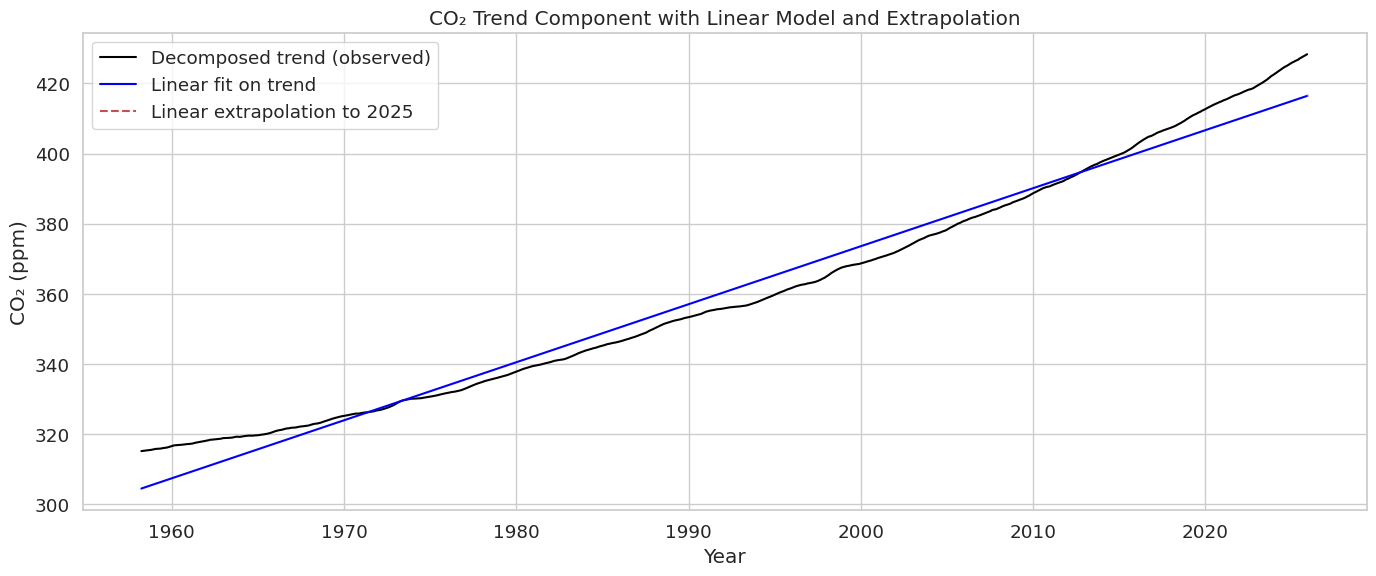

In [25]:
# Historical fit on trend
t_hist = trend_df["t"].values
trend_fit_hist = a * t_hist + b

# Future weekly dates until end of 2025
future_dates = pd.date_range(start=trend_df.index.max(), end="2025-12-27", freq="W-SAT")
f_year = future_dates.year
f_doy = future_dates.dayofyear
t_future = f_year + (f_doy - 0.5) / 365.25
trend_future = a * t_future + b

plt.figure(figsize=(14, 6))
plt.plot(trend_df.index, trend_df["trend"], label="Decomposed trend (observed)", color="black")
plt.plot(trend_df.index, trend_fit_hist, label="Linear fit on trend", color="blue")
plt.plot(future_dates, trend_future, "r--", label="Linear extrapolation to 2025")
plt.title("CO₂ Trend Component with Linear Model and Extrapolation")
plt.xlabel("Year")
plt.ylabel("CO₂ (ppm)")
plt.legend()
plt.tight_layout()
plt.show()
